# Underwriting Risk Scoring

Build an underwriting score regression model leveraging synthetic policy and exposure variables to support rate-making decisions.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

## 1. Generate synthetic underwriting data

In [2]:
rng = np.random.default_rng(21)
n_samples = 1500

exposure_months = rng.integers(6, 72, n_samples)
credit_score = rng.normal(710, 55, n_samples).clip(500, 850)
property_value = rng.normal(350000, 90000, n_samples).clip(50000, 900000)
prior_losses = rng.poisson(0.8, n_samples)
loss_ratio_history = rng.normal(0.45, 0.15, n_samples).clip(0.05, 1.5)
location_risk = rng.choice(["Coastal", "Metro", "Suburban", "Rural"], n_samples, p=[0.25, 0.35, 0.25, 0.15])
building_age = rng.normal(25, 12, n_samples).clip(0, 120)
policy_type = rng.choice(["Homeowners", "Renters", "Condo"], n_samples, p=[0.6, 0.25, 0.15])

risk_signal = (
    0.002 * (property_value / 1000)
    + 0.6 * loss_ratio_history
    + 0.003 * (exposure_months)
    + 0.4 * (building_age / 100)
    + 0.8 * (prior_losses > 1)
    - 0.004 * (credit_score - 650)
)
underwriting_score = np.clip(35 + 12 * risk_signal + rng.normal(0, 2, n_samples), 0, 100)

underwriting_df = pd.DataFrame(
    {
        "exposure_months": exposure_months,
        "credit_score": credit_score,
        "property_value": property_value,
        "prior_losses": prior_losses,
        "loss_ratio_history": loss_ratio_history,
        "location_risk": location_risk,
        "building_age_years": building_age,
        "policy_type": policy_type,
        "underwriting_score": underwriting_score,
    }
)

Path("data").mkdir(parents=True, exist_ok=True)
data_path = Path("data/underwriting_risk.csv")
underwriting_df.to_csv(data_path, index=False)
print(f"Dataset saved to {data_path.resolve()}")
underwriting_df.head()

Dataset saved to /Users/michaelmcdonogh/Documents/git/MachineLearningCalculateRiskPremium/CascadeProjects/windsurf-project/insurance-ml-demos/data/underwriting_risk.csv


,exposure_months,credit_score,property_value,prior_losses,loss_ratio_history,location_risk,building_age_years,policy_type,underwriting_score
0,25,660.795370,327543.216532,0,0.705596,Coastal,26.215635,Condo,49.582408
1,57,630.830228,403056.198108,1,0.480554,Suburban,27.129147,Homeowners,54.775484
2,31,730.691280,393126.690029,3,0.778623,Suburban,26.674373,Homeowners,60.812467
3,45,800.057177,371080.248144,2,0.460011,Metro,17.703301,Homeowners,52.985932
4,36,666.519726,254423.905437,2,0.533164,Metro,23.362027,Homeowners,58.438103


## 2. Exploratory analysis

In [3]:
df = pd.read_csv("data/underwriting_risk.csv")
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
exposure_months,1500.0,38.072000,19.033874,6.000000,22.000000,38.000000,54.000000,71.000000
credit_score,1500.0,713.675171,53.188307,545.170044,676.896112,713.292209,750.026508,850.000000
property_value,1500.0,346355.474025,89404.569727,50000.000000,287453.265216,346146.230155,406254.506799,665051.119042
prior_losses,1500.0,0.796000,0.897545,0.000000,0.000000,1.000000,1.000000,5.000000
loss_ratio_history,1500.0,0.452166,0.151602,0.050000,0.351020,0.451205,0.557570,0.991990
building_age_years,1500.0,24.747010,11.695323,0.000000,16.545096,24.853836,32.557616,63.170222
underwriting_score,1500.0,47.925897,5.598176,35.105914,43.858636,47.468781,51.225982,67.630555


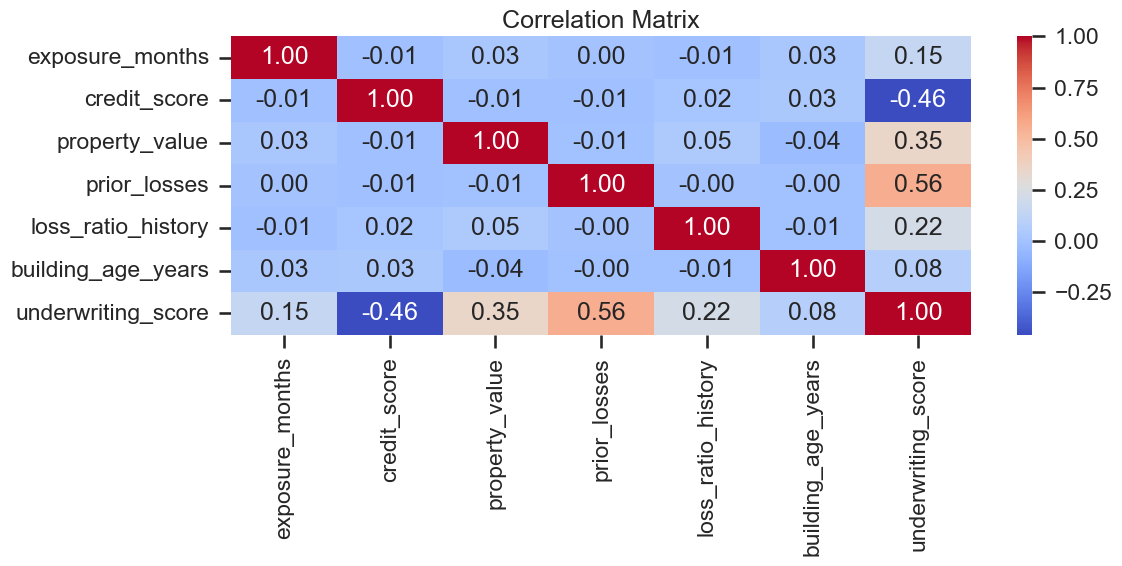

In [4]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## 3. Model training and diagnostics

In [5]:
features = pd.get_dummies(df.drop(columns=["underwriting_score"]), drop_first=True)
target = df["underwriting_score"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=21
)

model = GradientBoostingRegressor(random_state=21, n_estimators=350, learning_rate=0.05, max_depth=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2 : {r2:.3f}")

RMSE: 2.19
MAE: 1.74
R^2 : 0.842


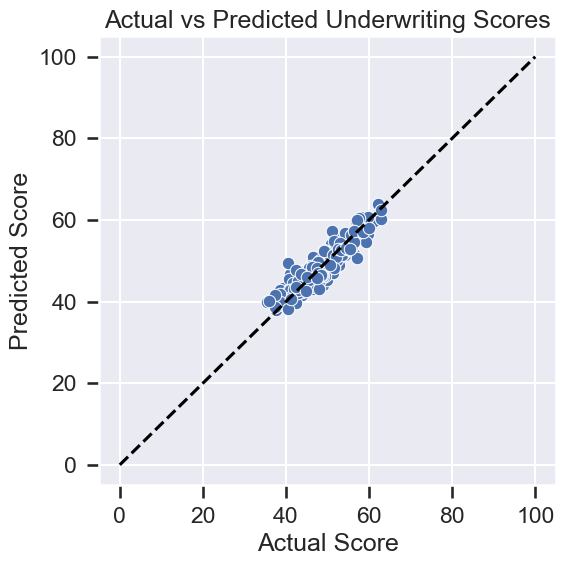

In [6]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([0, 100], [0, 100], color='black', linestyle='--')
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs Predicted Underwriting Scores")
plt.tight_layout()
plt.show()

/var/folders/d2/4vnsb4hn5vq5bb7wds771vx80000gn/T/ipykernel_55945/3394388745.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values[:15], y=importances.index[:15], orient='h', palette='crest')


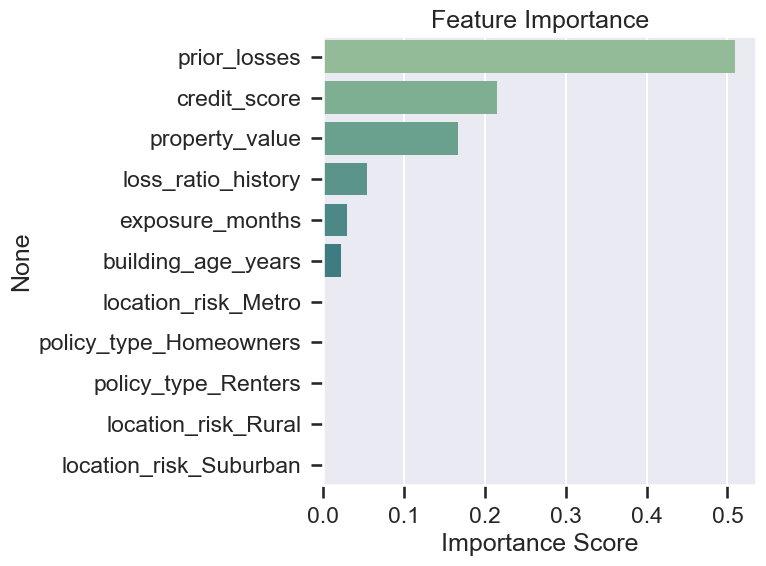

In [7]:
importances = pd.Series(model.feature_importances_, index=features.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=importances.values[:15], y=importances.index[:15], orient='h', palette='crest')
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()